Bias-Aware Clustering with
- KMeans
- DBSCAN
- MeanShift

And we analyse the variance of the clusters

### Init


In [2]:
# Loading the libraries
from util import *
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [100]:
raw_data = pd.read_csv(r'..\Preprocessed_datasets\preprocessed_wine.csv', index_col=0)
errors = raw_data['errors']
features = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)

### Scaling the features

In [4]:
# Scaling all attributes
to_scale = features.columns
features[to_scale] = StandardScaler().fit_transform(features[to_scale])
features[:5]

# Scaling the errors
errors_col = MinMaxScaler(feature_range = (0,1.0)).fit_transform(all_data[['errors']])
scaling_factor = 0.8 #needs to be converted to scaling range
scaled_errors = scaling_factor * errors_col

### Utils

In [5]:
# TODO: experiment with different random states, increase number of runs
clus_model_kwargs = {
    "n_clusters": 2,
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 2,
}

In [130]:
def get_random_cluster(clusters):
    """This function returns the value of a random cluster
    clusters Df.Column the column clusters"""
    result = -1
    while (result == -1):
        result = clusters.iloc[random.randint(0, len(clusters.unique()))]
    return result

def plot_clusters(data):    
    scatterplot = sns.scatterplot(data=data, x="alcohol", y="ash", hue="clusters", size='errors', sizes=(100, 20), palette="tab10")
    plt.show()

def accuracy(results):
    if len(results) == 0:
        print("You are calculating the accuracy on a empty cluster") 
    correct = results.loc[results['errors'] == 0]
    acc = len(correct)/len(results)
    return acc

def bias_acc(data, cluster_id, cluster_col):
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    if len(cluster_x) ==0:
        print("This is an empty cluster! cluster ", cluster_id)
    remaining_clusters = data.loc[data[cluster_col] != cluster_id]
    if len(remaining_clusters) == 0:
        print("This cluster is the entire dataset. cluster ", cluster_id)
    return accuracy(remaining_clusters) - accuracy(cluster_x)

def bias_acc_towards_global_average(data, cluster_id, cluster_col, ave_acc):
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    return ave_acc - accuracy(cluster_x)

def get_next_cluster(data):
    n_cluster = max(data['clusters'])
    highest_variance = -1
    cluster_number = 0

    for i in data['clusters'].unique():
        if (i == -1):
            continue
        cluster_i = data.loc[data['clusters'] == i]
        variance_cluster = np.var(cluster_i['errors'])
        
        if variance_cluster > highest_variance:
            highest_variance = variance_cluster
            cluster_number = i
            print('--> Cluster with the highest variance:', cluster_number)

    return cluster_number
def get_max_abs_bias(fulldata, function=bias_acc):
    """ This function returns the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters """
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = abs(function(fulldata, cluster_number, "new_clusters"))
        if current_bias > max_abs_bias:
            max_abs_bias = current_bias
    return max_abs_bias

def calculate_variance(data):
    for j in data['clusters'].unique():
        average_accuracy = accuracy(data)
        neg_bias_clus = bias_acc_towards_global_average(data, j, 'clusters', average_accuracy)
        neg_bias_list.append(neg_bias_clus)
    variance = np.var(neg_bias_list)
    return variance

def initialize_dataset(raw_data, just_features=True,scale_features=True, with_classes=True):
    new_data = raw_data.copy(deep=True)
    if just_features:
        new_data = new_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)
    
    if scale_features:
        to_scale = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1).columns
        new_data[to_scale] = StandardScaler().fit_transform(features[to_scale])
    
    if with_classes:
        for col in ['predicted_class', 'true_class', 'errors']:
            new_data[col] = raw_data[col]

    new_data['clusters'] = 0
    new_data['new_clusters'] = -1
    return new_data

def get_min_cluster_size(data):
    """Returns the size of the smallest new cluster"""
    min_cluster_size = len(data)
    for i in data['new_clusters'].unique():
        if i == -1:
            continue
        size = len(full_data.loc[full_data['new_clusters']==i])
        if size < min_cluster_size:
            min_cluster_size = size
    return min_cluster_size

## KMeans Clustering without errors as feature 

In [124]:
# Combine scaled features w. class & error labels
full_data = initialize_dataset(raw_data)
full_data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,predicted_class,true_class,errors,clusters,new_clusters
12,0.687846,-0.160373,0.141557,-0.694417,-0.834587,0.004312,0.267992,-0.318793,0.017405,0.697247,0.405843,-0.146241,1.256507,0,0.0,0.0,0,-1
23,-0.356751,-0.343481,0.502356,-0.101678,-0.381526,-0.222556,-0.278564,-0.635733,-0.650337,-0.367414,-0.033392,1.394286,0.408775,1,0.0,1.0,0,-1
25,-0.124619,0.290352,2.798346,2.269277,1.808272,0.061029,0.155878,1.582845,0.227267,-0.590546,0.259431,0.486852,-0.105424,0,0.0,0.0,0,-1
35,0.374467,-0.047692,0.141557,0.787430,-0.003974,0.193369,0.576306,-0.635733,0.112797,0.378486,-0.399421,1.056636,0.144727,1,0.0,1.0,0,-1
13,1.848509,-0.160373,0.075958,-2.209194,-0.683567,0.949596,1.571320,1.160258,1.925240,0.569743,1.137900,-0.504994,0.784001,2,0.0,1.0,0,-1


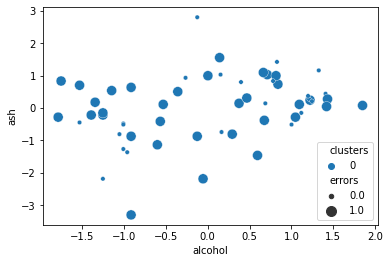

average_accuracy is:  0.40350877192982454
------------------------ [0 1]


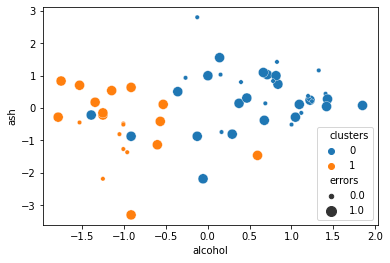

--> Cluster with the highest variance: 0
------------------------ [ 1.  0. -1.]


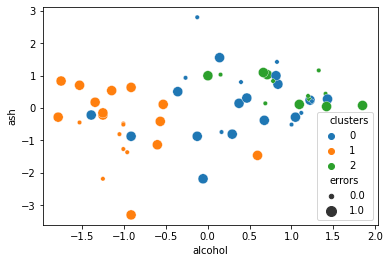

--> Cluster with the highest variance: 2
------------------------ [ 1. -1.  0.]


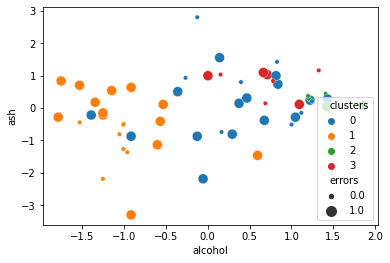

--> Cluster with the highest variance: 3
------------------------ [ 1. -1.  0.]


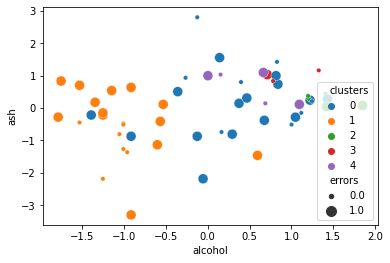

--> Cluster with the highest variance: 4
------------------------ [-1.  1.  0.]
------------------------ [-1.  1.  0.]
------------------------ [-1.  1.  0.]
------------------------ [-1.  0.  1.]
------------------------ [-1.  0.  1.]
------------------------ [-1.  1.  0.]
------------------------ [-1.  1.  0.]
MAX_ITER
[0.018383992892665672, 0.018259371877973368, 0.018156947776583516, 0.018180866157516233, 0.018202214129565915, 0.018221209648271865, 0.01823805041863726, 0.018252916016188944, 0.018265969758862934, 0.018277360362203156, 0.018287223405709152, 0.018295682634241462, 0.01830285111506906, 0.018308832268321817, 0.018313720786210547, 0.018317603454329694, 0.018320559886607125, 0.01832266318396574]


In [125]:
MAX_ITER = 20
x = 0 # cluster number
initial_bias = 0
plot_clusters(full_data)
variance_list = []
average_accuracy = accuracy(full_data) 
minimal_splittable_cluster_size = 8
minimal_acceptable_cluster_size = 1
print("average_accuracy is: ", average_accuracy) 

for i in range(1, MAX_ITER):
    if i != 1:
        variance_list.append(calculate_variance(full_data)) 
    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply Kmeans 
    kmeans_algo = KMeans(**clus_model_kwargs).fit(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1))
    
    candidate_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class',                                                                                                               'errors'], axis=1)),index=candidate_cluster.index) 
    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])

    max_abs_bias = get_max_abs_bias(full_data)
    min_new_size = get_min_cluster_size(full_data)
    
    if (max_abs_bias >= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): 
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        plot_clusters(full_data)
        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')

print(variance_list)

### Analysing the clustering results


<AxesSubplot:ylabel='variance excl errors'>

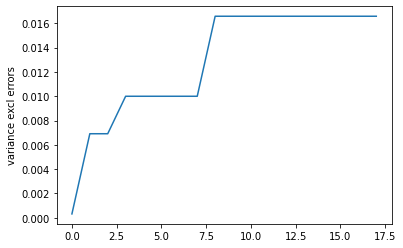

In [10]:
variance_df = pd.DataFrame(variance_list).rename(columns={0:"variance excl errors"})
sns.lineplot(data=variance_df, x=variance_df.index,y="variance excl errors")

## Bias-Aware DBSCAN

In [30]:
from sklearn.cluster import DBSCAN

In [138]:
# Combine scaled features w. class & error labels
full_data = initialize_dataset(raw_data)

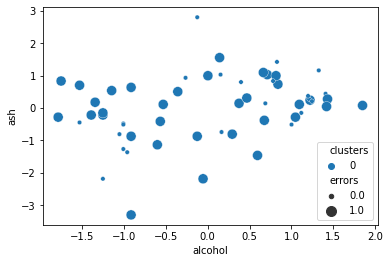

----- Clustering Iteration 1
Splitting on cluster 0


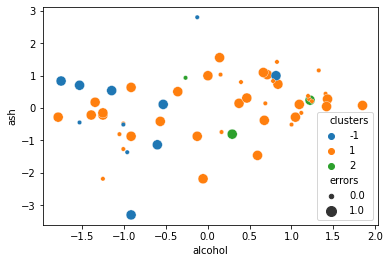

--> Cluster with the highest variance: 1
Variance clusters:  0.016584133842572943
----- Clustering Iteration 2
Splitting on cluster 1
Initial bias: 0.07407407407407407   -  Max abs. candidate bias: 0.06146179401993357
Min candidate size: 14
The selected cluster is not splitted. Picking a random cluster...
Variance clusters:  0.016584133842572943
----- Clustering Iteration 3
Splitting on cluster 1
Initial bias: 0.07407407407407407   -  Max abs. candidate bias: 0.06146179401993357
Min candidate size: 14
The selected cluster is not splitted. Picking a random cluster...
Variance clusters:  0.016584133842572943
----- Clustering Iteration 4
Splitting on cluster 1
Initial bias: 0.07407407407407407   -  Max abs. candidate bias: 0.06146179401993357
Min candidate size: 14
The selected cluster is not splitted. Picking a random cluster...
Variance clusters:  0.016584133842572943
----- Clustering Iteration 5
Splitting on cluster 1
Initial bias: 0.07407407407407407   -  Max abs. candidate bias: 0.06

In [139]:
MAX_ITER = 20
epsilon = 3
minimum_samples = 2 
x = 0 # cluster number
initial_bias = 0
plot_clusters(full_data)
variance_list = []
minimal_splittable_cluster_size = 7
minimal_acceptable_cluster_size = 1
average_accuracy = accuracy(full_data)

for i in range(1, MAX_ITER):
    if i != 1:
        variance_list.append(calculate_variance(full_data))
        print('Variance clusters: ', variance_clusters)
    print('----- Clustering Iteration', i)
    print('Splitting on cluster', x)

    full_data['new_clusters'] = -99
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        print('The selected cluster is not splitted. Picking a random cluster...')
        x = get_random_cluster(full_data['clusters'])
        continue
     
    candidate_cluster['new_clusters'] = pd.DataFrame(DBSCAN(eps=epsilon, min_samples=minimum_samples).fit_predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)), index=candidate_cluster.index)

    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])
        
    # calculate bias & cluster size for each of the two clusters
    max_abs_bias = get_max_abs_bias(full_data)
    min_cluster_size = get_min_cluster_size(full_data)

    if (max_abs_bias >= initial_bias) & (min_cluster_size > minimal_acceptable_cluster_size) & (len(full_data['new_clusters'].unique()) > 2): 
        # Add new cluster
        highest = max(full_data['clusters'].unique())

        for i in range(0, len(full_data['new_clusters'].unique())):
            full_data['clusters'][full_data['new_clusters'] == i] =  highest + i + 1
        full_data['clusters'][full_data['new_clusters'] == -1] = -1
        
        plot_clusters(full_data)
        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        print('Initial bias:', initial_bias, '  -  Max abs. candidate bias:', max_abs_bias)
        print('Min candidate size:', min_cluster_size)
        print('The selected cluster is not splitted. Picking a random cluster...')

        x = get_random_cluster(full_data['clusters'])
        # initial_bias = abs(bias_acc(full_data, x, 'clusters'))
        
print('MAX_ITER')

print(variance_list)

## Bias-Aware Mean Shift 

In [67]:
from sklearn.cluster import MeanShift, estimate_bandwidth 
initialize_dataset(full_data, features=features)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,true_class,predicted_class,errors,clusters,new_clusters
12,0.687846,-0.160373,0.141557,-0.694417,-0.834587,0.004312,0.267992,-0.318793,0.017405,0.697247,0.405843,-0.146241,1.256507,0.0,0,0.0,0,-1
23,-0.356751,-0.343481,0.502356,-0.101678,-0.381526,-0.222556,-0.278564,-0.635733,-0.650337,-0.367414,-0.033392,1.394286,0.408775,0.0,1,1.0,0,-1
25,-0.124619,0.290352,2.798346,2.269277,1.808272,0.061029,0.155878,1.582845,0.227267,-0.590546,0.259431,0.486852,-0.105424,0.0,0,0.0,0,-1
35,0.374467,-0.047692,0.141557,0.787430,-0.003974,0.193369,0.576306,-0.635733,0.112797,0.378486,-0.399421,1.056636,0.144727,0.0,1,1.0,0,-1
13,1.848509,-0.160373,0.075958,-2.209194,-0.683567,0.949596,1.571320,1.160258,1.925240,0.569743,1.137900,-0.504994,0.784001,0.0,2,1.0,0,-1


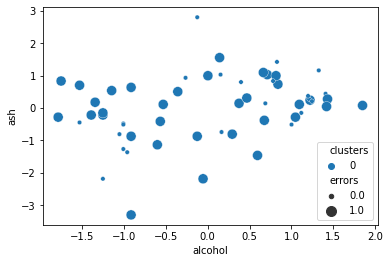

3          1.0                1     0.0         0            44  
41          0.0                2     1.0         0            25  
54          0.0                1     1.0         0            19  
24          0.0                0     0.0         0            23  
64          1.0                2     1.0         0            47  
28          0.0                0     0.0         0            14  
89          1.0                0     1.0         0            50  
92          1.0                1     0.0         0            36  
79          1.0                0     1.0         0            35  
14          0.0                2     1.0         0             2  
44          0.0                2     1.0         0            32  
66          1.0                2     1.0         0            30  
85          1.0                2     1.0         0            37  
99          1.0                1     0.0         0            43  
57          0.0                0     0.0         0            2

In [68]:
# klad

MAX_ITER = 20
# bw1 = estimate_bandwidth(features_i)
x = 0 # cluster number
initial_bias = 0
plot_clusters(full_data)
variance_list = []
average_accuracy = accuracy(full_data)

for i in range(1, MAX_ITER):
    if i != 1:
        generate_variance_list(full_data, variance_list) 
        print('Variance clusters: ', variance_clusters)
    print('----- Clustering Iteration', i)
    print('Splitting on cluster', x)

    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < 8:
        print('The selected cluster is not splitted. Picking a random cluster...')
        n_cluster = max(full_data['clusters'])
        x = random.randint(0, n_cluster)
        continue


    candidate_cluster['new_clusters'] = pd.DataFrame(MeanShift(bandwidth=0.5).fit_predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)), index=candidate_cluster.index)

    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])
        
    # calculate bias & cluster size for each of the two clusters
    max_abs_bias = -99999
    min_cluster_size = 1000
    print(full_data['new_clusters'].unique())
    print(full_data)
    for i in full_data['new_clusters'].unique(): #todo: make function
        negative_bias_i = abs(bias_acc(full_data, i, 'new_clusters'))
        size = len(full_data.loc[full_data['new_clusters']==i])
        if negative_bias_i >= max_abs_bias:
            max_abs_bias = negative_bias_i
        if size < min_cluster_size:
            min_cluster_size = size

    if (max_abs_bias >= initial_bias) & (min_cluster_size > 1): 
        # Add new cluster
        n_cluster = max(full_data['clusters'])

        highest = max(full_data['clusters'].unique())

        for i in range(0, len(full_data['new_clusters'].unique())):
            full_data['clusters'][full_data['new_clusters'] == i] =  highest + i + 1
        
        plot_clusters(full_data)
        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        print('Initial bias:', initial_bias, '  -  Max abs. candidate bias:', max_abs_bias)
        print('Min candidate size:', min_cluster_size)
        print('The selected cluster is not splitted. Picking a random cluster...')
        n_cluster = max(full_data['clusters'])
        x = random.randint(0, n_cluster)
        # initial_bias = abs(bias_acc(full_data, x, 'clusters'))
        
print('MAX_ITER')

print(variance_list)

<AxesSubplot:ylabel='variance excl errors'>

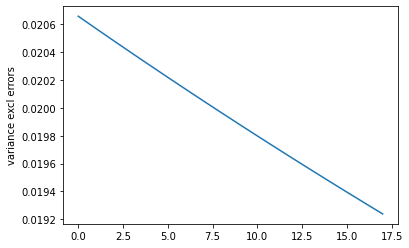

In [69]:
variance_df = pd.DataFrame(variance_list).rename(columns={0:"variance excl errors"})
sns.lineplot(data=variance_df, x=variance_df.index,y="variance excl errors")

## DBSCAN without recursivity

In [ ]:
var_list = []
epsilon = 3
minimum_samples = 2
features_i = features.copy(deep=True)
features_i["errors"] = errors

for n in range(2, 58):
    model = DBSCAN(eps=epsilon, min_samples=minimum_samples).fit_predict(features_i)
    features_i['cluster_results'] = pd.DataFrame(model, index=features_i.index)

    neg_bias_list = []
    epsilon = epsilon-0.1
    if  len(features_i["cluster_results"].unique()) == 1:
        print("One cluster left on iteration ", n)
        print("With epsilon", epsilon)
        break
    for i in features_i["cluster_results"].unique():
        print(features_i["cluster_results"].unique())
        #print('features_i', features_i)
        neg_bias_list.append(bias_acc(features_i, i,"cluster_results"))
    var_list.append(np.var(neg_bias_list))
print(var_list)

plt.plot(var_list)

In [18]:
# exporting the biased cluster dataframe for further analysis
import os
path = r'..\\Clustered_datasets\\'
# full_data.to_csv(os.path.join(path, r'biased_wine_clusters.csv'))
